This notebook will walk through some of the analysis that we did using Pythia12B on the MATH dataset.

In [362]:
import sys
import os
import src.analyze as analyze
import src.stats_utils as stats_utils
import src.mixtures as mixtures
import src.better_optimiation as bopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import src.better_em as BEM
import heapq

In [363]:
import importlib

importlib.reload(bopt)
importlib.reload(stats_utils)
importlib.reload(mixtures)

<module 'src.mixtures' from '/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/mixtures.py'>

In [364]:
# get data for the number of math problems solved
data = analyze.create_or_load_large_language_monkeys_pythia_math_pass_at_k_df()

# this tells us whether each attempt was a success or failure -- I don't think it adds any
# value given that the attempts were independent
individual_data = (
    analyze.create_or_load_large_language_monkeys_pythia_math_individual_outcomes_df()
)

Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_pass_at_k.parquet with shape:  (90496, 7)
Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_individual_outcomes.parquet with shape:  (8960000, 5)


In [365]:
# label the number of total samples and compute the number of correct attempts for each problem
data = data[data["Scaling Parameter"] == 1]
data["Num. Samples Total"] = 10000
data["Num. Samples Correct"] = data["Score"] * data["Num. Samples Total"]
data.head()

,Score,Scaling Parameter,Problem Idx,Model,Benchmark,Log Score,Neg Log Score,Num. Samples Total,Num. Samples Correct
0,0.0122,1,0,Pythia 12B,MATH,-4.406319,4.406319,10000,122.0
1,0.0032,1,1,Pythia 12B,MATH,-5.744604,5.744604,10000,32.0
2,0.0167,1,2,Pythia 12B,MATH,-4.092347,4.092347,10000,167.0
3,0.0001,1,3,Pythia 12B,MATH,-9.210340,9.210340,10000,1.0
4,0.2227,1,4,Pythia 12B,MATH,-1.501930,1.501930,10000,2227.0


In [366]:
# let's start by looking at the math dataset
math_data = data[data["Benchmark"] == "MATH"]

In [367]:
# let's look at Pythia12B only
model = "Pythia 12B"
pythia12_math = math_data[math_data["Model"] == model]

In [286]:
# Fix: Use integer division operator and ensure equal groups
num_samples_total = 150
pythia12_math["Num. Samples Total"] = num_samples_total * np.ones(len(pythia12_math))

half_len = len(pythia12_math) // 2  # Use integer division operator

# Create two groups with different means
group1_probs = np.clip(np.random.randn(half_len) / 10 + 0.1, 0.00001, 1)
group2_probs = np.clip(
    np.random.randn(len(pythia12_math) - half_len) / 10 + 0.9, 0.00001, 1
)

# Concatenate instead of stack
probs = np.concatenate([group1_probs, group2_probs])

samples_correct = np.round(pythia12_math["Num. Samples Total"] * probs)
pythia12_math["Score"] = probs
pythia12_math["Num. Samples Correct"] = samples_correct

/var/folders/sc/fyw6v7ks5mnfw0twp1p1k4mr0000gn/T/ipykernel_96392/2704655172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pythia12_math['Num. Samples Total'] = num_samples_total * np.ones(len(pythia12_math))
/var/folders/sc/fyw6v7ks5mnfw0twp1p1k4mr0000gn/T/ipykernel_96392/2704655172.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pythia12_math['Score'] = probs
/var/folders/sc/fyw6v7ks5mnfw0twp1p1k4mr0000gn/T/ipykernel_96392/2704655172.py:16: SettingWithCopyWarning: 
A value is trying to be set on

A brief overview of the fitting methods:
- The two parameter beta distribution is fit on estimated probabilities using scipy
- The three parameter beta distribution is again fit with scipy using an estimated scale parameter given by highest_observed_success_rate*(num_samples+1)/num_samples.  Although this choice of scale parameter would cause make the likelihood under this model of observing higher pass@1 on a new question 0.  Therefore, this model is bad when trying to extrapolate to a test set of witheld problems, but good when estimating scaling laws (because if we don't observe a single success for a given question in 10,000 samples, it's unlikely that the true pass@1 is higher than 22.7%)  This is more of a problem if we specifically care about estimating the distribution rather than the power law, or if we have fewer samples.
- The discretized beta distribution: We bin the success probabilities before fitting the beta distribution directly on the fitted probabilities.  The binning occurs on a log scale to prioritize fitting the left tail of the distribution accurately.  This fit is designed for estimating power laws in the low-sample regime.  

In [287]:
beta_2_params = (
    analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(
        pythia12_math
    )
)
print("finished beta 2")
beta_2_params_stable = bopt.fit_beta_binomial_two_parameters_stable(pythia12_math)
print("finished beta 2 stable")
beta_3_params = (
    analyze.fit_beta_binomial_three_parameters_to_num_samples_and_num_successes(
        pythia12_math
    )
)
print("finished beta 3")
beta_3_discretized_params = (
    analyze.fit_discretized_beta_three_parameters_to_num_samples_and_num_successes(
        pythia12_math
    )
)  #
print("finished beta 3 discrete")

finished beta 2
finished beta 2 stable
the scale is 1.0
finished beta 3
finished beta 3 discrete


In [288]:
# result of fitting a 2-parameter beta
beta_2_params

alpha                  0.370633
beta                   0.373714
loc                    0.000000
scale                  1.000000
neg_log_likelihood     4.602596
aic                   13.205192
bic                   28.139494
Power Law Exponent     0.370633
dtype: float64

In [289]:
beta_2_params_stable

alpha                   0.367752
beta                    0.372151
loc                     0.000000
scale                   1.000000
neg_log_likelihood     47.244863
aic                    98.489726
bic                   113.424027
Power Law Exponent      0.367752
dtype: float64

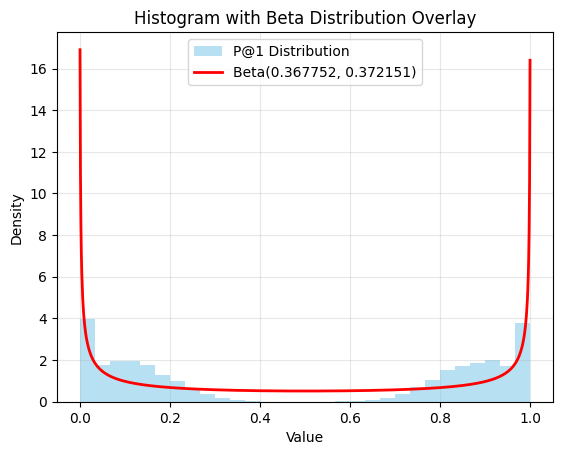

In [290]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_2_params_stable)

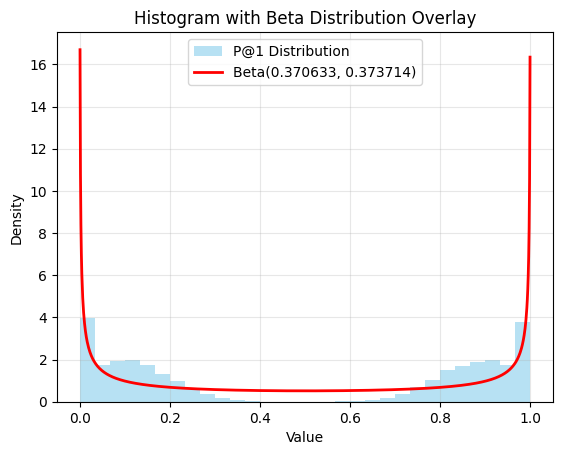

In [291]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_2_params)

Both of the 3-parameter beta fits work comparably when we are fitting large amounts of data.

In [292]:
print("Beta 3 params")
print(beta_3_params)
print("Beta 3 params discretized")
print(beta_3_discretized_params)

Beta 3 params
alpha                 0.370634
beta                  0.373674
loc                        0.0
scale                      1.0
neg_log_likelihood    4.602596
maxiter                   5000
success                Success
dtype: object
Beta 3 params discretized
alpha                  0.302632
beta                   0.340491
loc                         0.0
scale                       1.0
neg_log_likelihood    70.212994
success                 Success
dtype: object


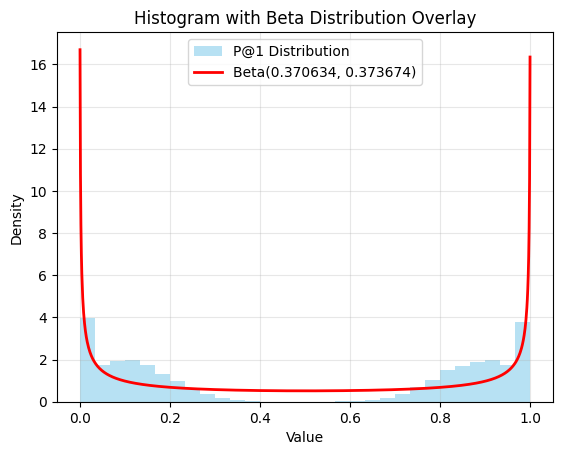

In [293]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_3_params)

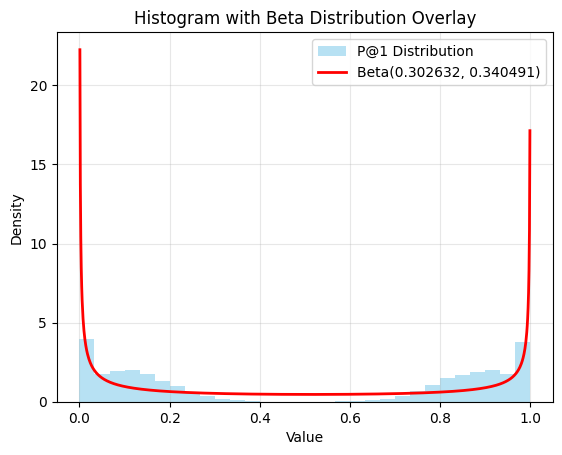

In [294]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_3_discretized_params)

Now that we have observed the high-samples regime, let's look at what happens when there is only a small number of samples for each problem -- we will subsample only 20 attempts per problem and refit the distributions. Note that in order to fit the scaling law, beta is irrelevant.  Therefore, we are interested in understanding how close we can get to alpha.   

In [295]:
data.head()

,Score,Scaling Parameter,Problem Idx,Model,Benchmark,Log Score,Neg Log Score,Num. Samples Total,Num. Samples Correct
0,0.0122,1,0,Pythia 12B,MATH,-4.406319,4.406319,10000,122.0
1,0.0032,1,1,Pythia 12B,MATH,-5.744604,5.744604,10000,32.0
2,0.0167,1,2,Pythia 12B,MATH,-4.092347,4.092347,10000,167.0
3,0.0001,1,3,Pythia 12B,MATH,-9.210340,9.210340,10000,1.0
4,0.2227,1,4,Pythia 12B,MATH,-1.501930,1.501930,10000,2227.0


In [296]:
smaller_data = data[[]]
samples = 100
probs = pythia12_math[
    "Score"
]  # np.clip(np.random.randn(len(pythia12_math['Score'])), 0.00001, 1-0.00001)
smaller_data = {
    "Num. Samples Correct": np.random.binomial(n=samples, p=probs),
    "Num. Samples Total": np.ones(len(pythia12_math)) * samples,
}
smaller_pythia12_math = pd.DataFrame(smaller_data)
smaller_pythia12_math["Score"] = (
    smaller_pythia12_math["Num. Samples Correct"]
    / smaller_pythia12_math["Num. Samples Total"]
)

In [297]:
smaller_pythia12_math.head()

,Num. Samples Correct,Num. Samples Total,Score
0,10,100.0,0.10
1,0,100.0,0.00
2,1,100.0,0.01
3,8,100.0,0.08
4,9,100.0,0.09


We refit the data using the same three methods as before.  We will take the expectation of the resulting beta binomials and see which one estimates the largest pass@k for the full data.  

In [298]:
import importlib

importlib.reload(bopt)
importlib.reload(stats_utils)
importlib.reload(mixtures)

<module 'src.mixtures' from '/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/mixtures.py'>

In [299]:
smaller_beta_2_params = (
    analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)
smaller_beta_2_params_stable = bopt.fit_beta_binomial_two_parameters_stable(
    smaller_pythia12_math
)
smaller_beta_3_params = (
    analyze.fit_beta_binomial_three_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)
smaller_beta_3_discretized_params = (
    analyze.fit_discretized_beta_three_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)

the scale is 1.0


In [300]:
smaller_beta_2_params_stable

alpha                  0.362671
beta                   0.366215
loc                    0.000000
scale                  1.000000
neg_log_likelihood    31.724047
aic                   67.448094
bic                   82.382396
Power Law Exponent     0.362671
dtype: float64

Let's now plot the beta fit along with the entire distribution.

alpha                  0.365018
beta                   0.368421
loc                    0.000000
scale                  1.000000
neg_log_likelihood     4.205415
aic                   12.410829
bic                   27.345131
Power Law Exponent     0.365018
dtype: float64


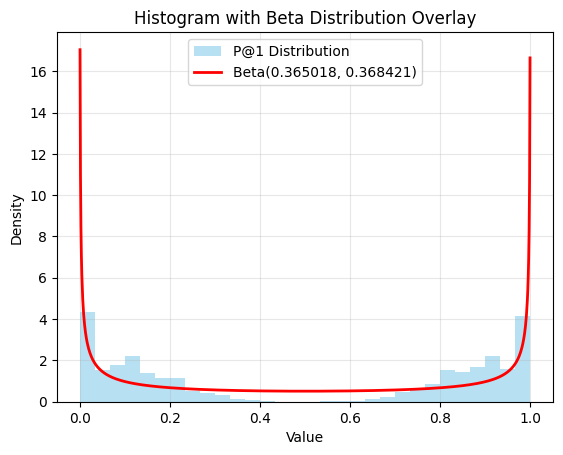

In [301]:
print(smaller_beta_2_params)
stats_utils.plot_histo_and_beta(smaller_pythia12_math["Score"], smaller_beta_2_params)

alpha                 0.365023
beta                  0.368429
loc                        0.0
scale                      1.0
neg_log_likelihood    4.205415
maxiter                   5000
success                Success
dtype: object


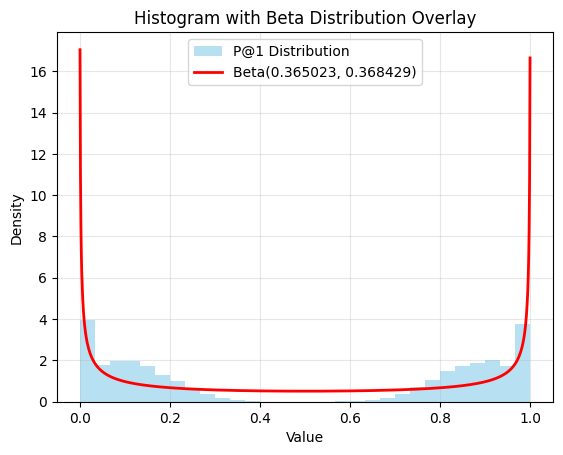

In [302]:
print(smaller_beta_3_params)
stats_utils.plot_histo_and_beta(pythia12_math["Score"], smaller_beta_3_params)

alpha                  0.285943
beta                   0.328471
loc                         0.0
scale                       1.0
neg_log_likelihood    69.564268
success                 Success
dtype: object


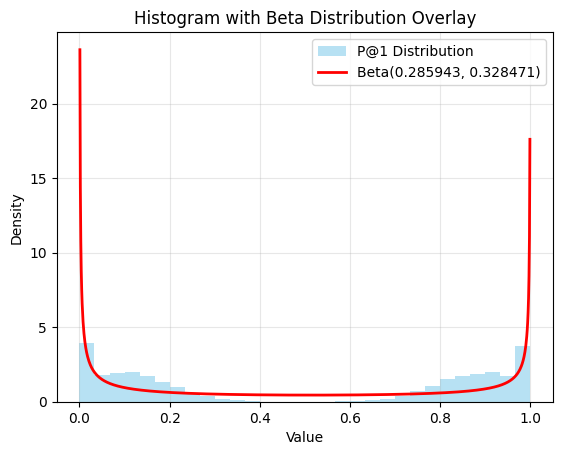

In [303]:
print(smaller_beta_3_discretized_params)
stats_utils.plot_histo_and_beta(
    pythia12_math["Score"], smaller_beta_3_discretized_params
)

Now let's measure how far off $\alpha$ is for each of these fits from the originals.

In [304]:
print(f'beta_2_params error: {beta_2_params['alpha']-smaller_beta_2_params['alpha']}')
print(f'beta_3_params error: {beta_3_params['alpha'] - smaller_beta_3_params['alpha']}')
print(f'beta_3_discretized_error: {beta_3_discretized_params['alpha'] - smaller_beta_3_discretized_params['alpha']}')

beta_2_params error: 0.005614692967066515
beta_3_params error: 0.0056108063468569
beta_3_discretized_error: 0.01668937942891624


In [305]:
# p@k new
np.mean(1 - (1 - probs) ** pythia12_math["Num. Samples Total"].max())

0.9113341548770609

In [306]:
# let's compute the true pass@k
p_at_k = 1 - (len(pythia12_math[pythia12_math["Num. Samples Correct"] == 0])) / len(
    pythia12_math
)
print(f"Measured pass@k success rate: {p_at_k}")

Measured pass@k success rate: 0.9160736386138614


Let's also compute the predicted pass@k for each of the predicted beta-binomials.  Specifically, we want to compute:

$1-\int_0^1 {n\choose{0}}(1-p)^k dG(p)$ where $G(p)$ is the fitted beta distribution.

Let's estimate pass@k from both the subset of data and the full data for each method

In [307]:
smaller_beta_2_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(smaller_beta_2_params["alpha"], smaller_beta_2_params["beta"]),
        scale=1.0,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_2_pass_at_10000

0.9820774937308585

In [308]:
smaller_beta_2_stable_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_2_params_stable["alpha"],
            smaller_beta_2_params_stable["beta"],
        ),
        scale=1.0,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_2_stable_pass_at_10000

0.9817049699149978

In [309]:
beta_2_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(beta_2_params["alpha"], beta_2_params["beta"]),
        scale=1.0,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
beta_2_pass_at_10000

0.9829365960744236

In [310]:
smaller_beta_2_pass_at_10000_stable = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_2_params_stable["alpha"],
            smaller_beta_2_params_stable["beta"],
        ),
        scale=1.0,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_2_pass_at_10000_stable

0.9817049699149978

This is strange!  The data fit on the subset is a better estimator of the true pass@k than the data fit on the entire set

In [311]:
smaller_beta_3_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(smaller_beta_3_params["alpha"], smaller_beta_3_params["beta"]),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_3_pass_at_10000

0.9820781773606163

In [312]:
beta_3_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(beta_3_params["alpha"], beta_3_params["beta"]),
        scale=beta_3_params["scale"],
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
beta_3_pass_at_10000

0.9829379352478136

In [339]:
smaller_beta_3_discrete_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([pythia12_math["Num. Samples Total"].max()]),
        num_successes=np.array([0]),
    )
)
smaller_beta_3_discrete_pass_at_10000

0.8721719741858465

In [ ]:
smaller_beta_3_discrete_pass_at_100 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([pythia12_math["Num. Samples Total"].max()]),
        num_successes=np.array([0]),
    )
)
smaller_beta_3_discrete_pass_at_10000

In [340]:
# the better estimator:
discrete_at_9900 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([pythia12_math["Num. Samples Total"].max() - samples]),
        num_successes=np.array([0]),
    )
)
(
    discrete_at_9900
    * len(smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] == 0])
    + len(smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0])
) / len(smaller_pythia12_math)

0.983550755620951

In [341]:
beta_3_discrete_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(beta_3_discretized_params["alpha"], beta_3_discretized_params["beta"]),
        scale=beta_3_params["scale"],
        num_samples=np.array([pythia12_math["Num. Samples Total"].max()]),
        num_successes=np.array([0]),
    )
)
beta_3_discrete_pass_at_10000

0.882881509349126

In [316]:
smaller_beta_3_discrete_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([pythia12_math["Num. Samples Total"].max()]),
        num_successes=np.array([0]),
    )
)
smaller_beta_3_discrete_pass_at_10000

0.8721719741858465

In [ ]:
smaller_beta_3_discrete_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([pythia12_math["Num. Samples Total"].max()]),
        num_successes=np.array([0]),
    )
)
smaller_beta_3_discrete_pass_at_10000

Rylan claimed that the pass@k estimates for the discretized distribution were superior.  Based on this analysis, the standard beta binomial estimator seems to work better.  There are many more models and datasets that one could analyze, though.  Maybe this observation doesn't hold widely across models.  It does seem fairly spectacular that with just 10 samples per problem we are able to estimate pass@k using this method within 2%.  

In [348]:
fail_all = (
    analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([pythia12_math["Num. Samples Total"].max()]),
        num_successes=np.array([0]),
    )
)
fail_first = (
    analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([smaller_pythia12_math["Num. Samples Total"].max()]),
        num_successes=np.array([0]),
    )
)
succeed_first = len(
    smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0]
)
fail_first_true = len(smaller_pythia12_math) - succeed_first
questions = len(smaller_pythia12_math)
print(succeed_first / questions)
best_estimate = (
    (fail_first_true - fail_all * questions) / fail_first_true + succeed_first
) / questions
best_estimate

0.9060179455445545


0.9044022357401887

In [317]:
smaller_pythia12_math

,Num. Samples Correct,Num. Samples Total,Score
0,10,100.0,0.10
1,0,100.0,0.00
2,1,100.0,0.01
3,8,100.0,0.08
4,9,100.0,0.09
...,...,...,...
12923,89,100.0,0.89
12924,100,100.0,1.00
12925,100,100.0,1.00
12926,100,100.0,1.00


Finally, let's look at the original estimator developed for fitting power laws.

In [318]:
# original estimator
ks = np.array([i for i in range(1, samples)])
pass_at_ks = analyze.compute_pass_at_k_from_num_samples_and_num_successes_df(
    smaller_pythia12_math, ks
)
pass_at_ks = pass_at_ks.groupby("Scaling Parameter")["Score"].mean()
model = LinearRegression(fit_intercept=True)
model.fit(np.log(ks).reshape(-1, 1), -np.log(pass_at_ks))
np.exp(-model.predict(np.log([10000]).reshape(-1, 1)))

array([1.47664302])

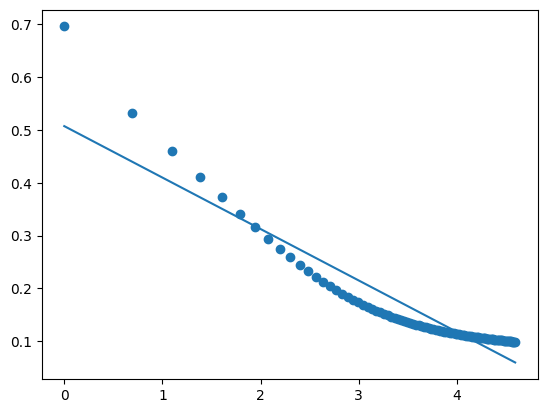

In [319]:
plt.scatter(np.log(ks), -np.log(pass_at_ks))
plt.plot(np.log(ks), model.predict(np.log(ks).reshape(-1, 1)))

In [320]:
model.intercept_

0.5072438996419818


Define $\eta_x = \mathbb{E}[n_x]$, or the expected number of samples observed $x$ times in the first $[-k, 0)$ trials (we write this as a continuous interval to be consistent with Efron, but really it is $\{-k, -k+1,...,-1\})$.

Under our model using Efron's notation, $$\eta_x = S\int_0^1 {k\choose{x}} p^x(1-p)^{k-x} dG(p)$$.
Let $t= n/k<1$, i.e. the number of new samples divided by the number of samples taken so far.  We also will need to assume that all of the probabilities are small in the sense that $(1-p_i)^n \approx (1-np_i)$ for all probabilities and $(1-p_i)^k \approx (1-p_i)^n$.  This is an obviously unrealistic assumption in our case.  We want to estimate the number of additional problems that we will solve at least once if we take $n$ additional samples.  In expectation, this is given by $$\Delta_{t}(x) = S\int_0^1 (1-p)^k(1-(1-p)^n)dG(p).$$  

We can rewrite this as 
$$ \Delta_t(x) = S \int_0^1 (1-p)^k-(1-p)^{n}(1-p)^{k} \\ = \eta_0 - S\int_0^1 (1-p)^{n+k}.$$

We use Poisson approximation in order to resolve the second term in terms of $\eta_x$.  First, we need to assume a low time horizon, i.e. $0<t<1$ and small p.  Under these assumptions, we get

$$  \sum_{i=0}^{n+k} {n+k\choose{i}}(-p)^i \\ = \sum_{i=0}^{k} {k\choose{i}}(-p)^i (1-p)^{n-i} \\ \approx \sum_{i=0}^k {k\choose{i}}(-p)^i (1-p)^{k-i}.$$

If one integrates this expression over the distribution of probabilities, one recovers $\eta_0 - \sum (-1)^i \eta_i$.


In [321]:
stats_utils.compute_efron_estimator(smaller_pythia12_math, predicted_samples=5)

1.9831816566436503e+67

In [342]:
def compute_bin_estimator(data, predicted_samples):
    largest_success_rate = data["Num. Samples Correct"].max()
    total = 0
    for i in range(1, largest_success_rate):
        term = len(data[data["Num. Samples Correct"] == i]) * (-1) ** (i + 1)
        total += term

    total += len(data[data["Num. Samples Correct"] != 0])
    total /= len(data)
    return total


compute_bin_estimator(smaller_pythia12_math, predicted_samples=0)

0.9303836633663366

In [343]:
import importlib

importlib.reload(bopt)
importlib.reload(stats_utils)
importlib.reload(mixtures)
importlib.reload(EM)
importlib.reload(BEM)

<module 'src.better_em' from '/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/better_em.py'>

In [344]:
n_distr = 3

In [325]:
import src.EM as EM

beta_mixture = BEM.beta_binom_mixture(
    n_distr=n_distr,
    num_successes=smaller_pythia12_math["Num. Samples Correct"],
    num_trials=smaller_pythia12_math["Num. Samples Total"],
)
beta_mixture_params = beta_mixture.fit_mixture()
# beta_mixture_params = EM.fit_beta_binomial_mixture_em(smaller_pythia12_math['Num. Samples Total'], smaller_pythia12_math['Num. Samples Correct'], n_distr)

0: nll: 9815.921668404464
1: nll: 21893.264079533612
2: nll: 8995.396830096375
0: nll: 10050.166502933418
1: nll: 22008.04916958639
2: nll: 8899.151766162242
0: nll: 10337.363360727577
1: nll: 22023.16469752378
2: nll: 8732.996064205572
0: nll: 10636.423398376253
1: nll: 22015.931429249107
2: nll: 8514.917676006287
0: nll: 10934.05876998789
1: nll: 22009.039391820534
2: nll: 8262.022352747348
0: nll: 11228.84706128261
1: nll: 22003.74569358491
2: nll: 7989.522687730214
0: nll: 11491.68333977585
1: nll: 22011.460209779092
2: nll: 7692.6319542914525
0: nll: 11706.223440615839
1: nll: 22009.075960007198
2: nll: 7464.229519711474
0: nll: 11981.818645650428
1: nll: 22004.7523194835
2: nll: 7189.131099121889
0: nll: 12190.58230991316
1: nll: 22004.917273209536
2: nll: 6959.112342927325
0: nll: 12371.822771106456
1: nll: 22007.629373104184
2: nll: 6753.070451566558
0: nll: 12606.5842131969
1: nll: 22002.225567660164
2: nll: 6519.251275041092
0: nll: 12786.308926691243
1: nll: 22004.3674546279

In [326]:
print(beta_mixture_params)

{'alpha_0': 18.895954192918733, 'beta_0': 3.1309937947992452, 'pi_0': 0.35779142267394487, 'alpha_1': 0.7621254425869526, 'beta_1': 6.480694876973849, 'pi_1': 0.5016383558925974, 'alpha_2': 8.659467366467144, 'beta_2': 0.17386921345127435, 'pi_2': 0.14057022143345782}


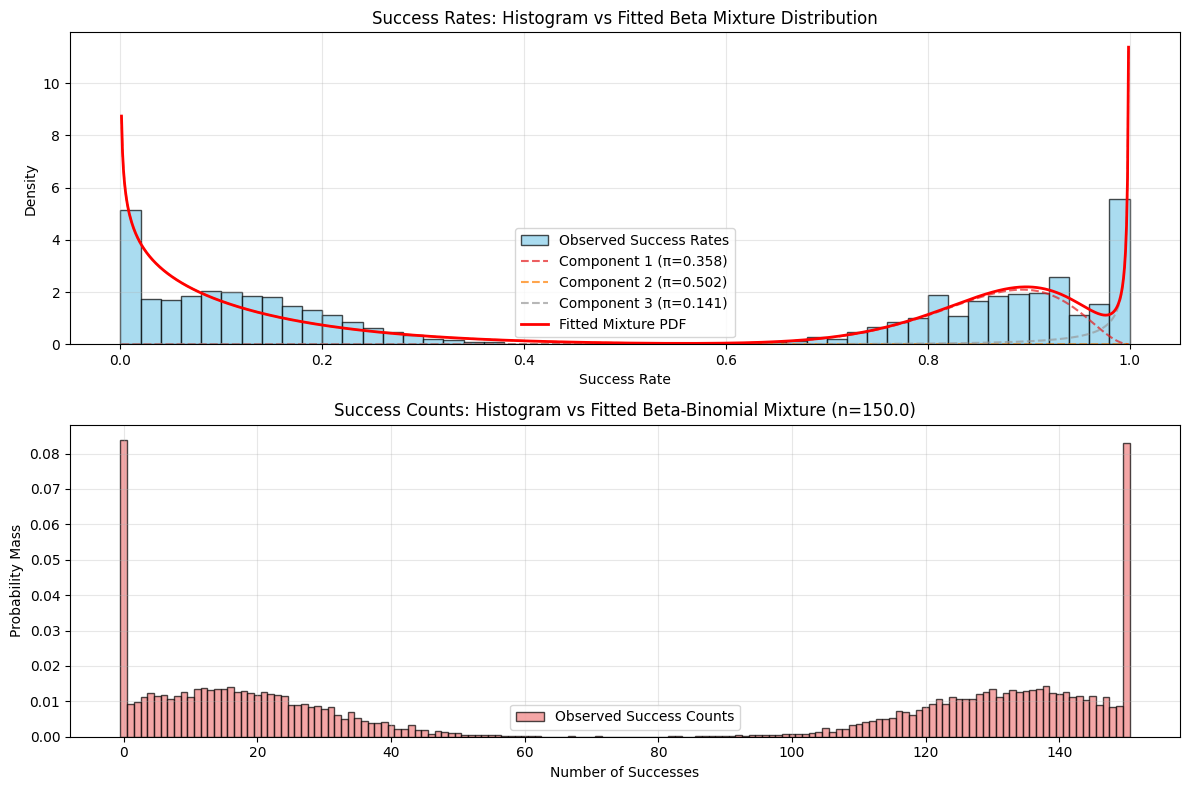

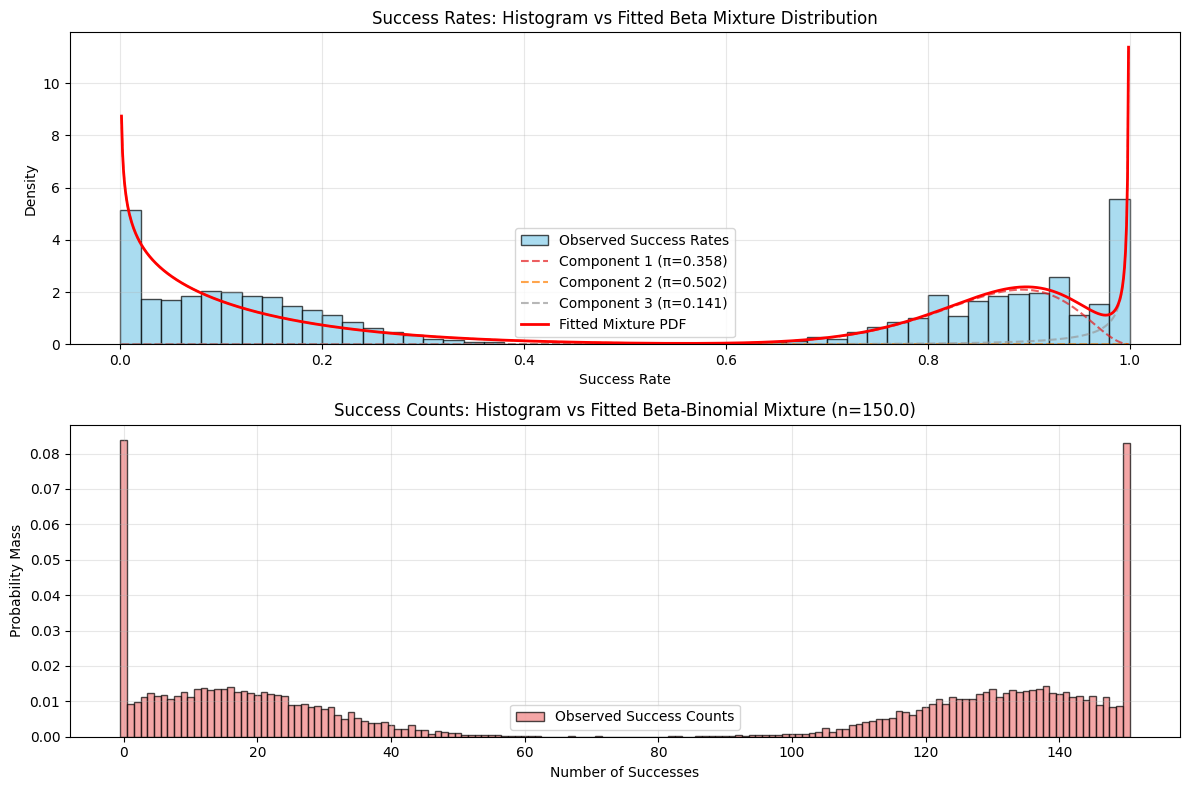

In [327]:
mixtures.plot_beta_binomial_mixture_with_histogram(
    pythia12_math, beta_mixture_params, n_distr
)

In [328]:
# beta_mixture_params['pi_0'] =1
probs = [beta_mixture_params[f"pi_{i}"] for i in range(n_distr - 1)]
probs = np.array(probs + [1 - sum(probs)])
log_probs = bopt.compute_component_log_pmfs(
    0, num_samples_total, beta_mixture_params, n_distr=n_distr
) + np.log(probs)
1 - np.exp(scipy.special.logsumexp(log_probs))

0.9780645037099728

In [329]:
expected = EM.compute_expected_pass_at_k(
    beta_mixture_params, n_distr, samples, num_samples_total
)
expected + len(
    smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0]
) / len(pythia12_math)

0.9346721953306232

In [349]:
fail_all_mixture = EM.compute_expected_pass_at_k(
    beta_mixture_params, n_distr, 0, num_samples_total
)
# fail_first = analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(params = (smaller_beta_3_discretized_params['alpha'], smaller_beta_3_discretized_params['beta']), scale = smaller_beta_3_params['scale'], num_samples = np.array([smaller_pythia12_math['Num. Samples Total'].max()]), num_successes = np.array([0]) )
succeed_first = len(
    smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0]
)
fail_first_true = len(smaller_pythia12_math) - succeed_first
questions = len(smaller_pythia12_math)
print(succeed_first / questions)
best_estimate = (
    (fail_first_true - fail_all_mixture * questions) / fail_first_true + succeed_first
) / questions
best_estimate

0.9060179455445545


0.9053082416465582

In [331]:
log_probs

array([[-53.54364647,  -3.81964912, -38.96308844]])

In [332]:
# chao's estimator
fraction_solved_1 = smaller_pythia12_math[
    smaller_pythia12_math["Num. Samples Correct"] == 1
].count()  # /len(smaller_pythia12_math)

In [333]:
fraction_solved_2 = smaller_pythia12_math[
    smaller_pythia12_math["Num. Samples Correct"] == 2
].count()  # /len(smaller_pythia12_math)

In [334]:
(
    smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0].count()
    + fraction_solved_1 * (fraction_solved_1 - 1) / (2 * (fraction_solved_2 + 1))
) / len(smaller_pythia12_math)

Num. Samples Correct    0.913157
Num. Samples Total      0.913157
Score                   0.913157
dtype: float64

In [335]:
def good_turing(data):
    largest_success_rate = data["Num. Samples Correct"].max()
    total = 0
    for i in range(largest_success_rate + 1):
        solved_i = len(data[data["Num. Samples Correct"] == i])
        solved_iadd1 = len(data[data["Num. Samples Correct"] == i + 1])
        smoothed_n_i = (i + 1) * solved_iadd1 / solved_i
        print(smoothed_n_i)
        if i < 3:
            p_hat_i = i / samples  # smoothed_n_i / data['Num. Samples Total'].max()
        else:
            p_hat_i = i / samples
        total += solved_i * (1 - (1 - p_hat_i) ** 1e5)
    return total, total / len(data)

In [336]:
good_turing(smaller_pythia12_math)

0.17037037037037037
2.2222222222222223
2.752173913043478
3.924170616113744
5.314009661835748
6.654545454545454
7.114754098360656
8.096774193548388
9.215139442231076
8.521400778210117
13.159817351598173
10.900763358778626
13.382352941176471
12.17142857142857
15.28169014084507
12.165898617511521
20.70909090909091
13.432835820895523
18.366666666666667
17.517241379310345
20.834645669291337
21.126984126984127
22.619834710743802
17.747899159663866
18.181818181818183
28.03125
22.695652173913043
24.620689655172413
37.529411764705884
20.454545454545453
23.42222222222222
24.470588235294116
33.0
31.384615384615383
20.416666666666668
28.285714285714285
40.36363636363637
28.5
30.333333333333332
11.428571428571429
123.0
49.0
18.428571428571427
14.666666666666666
90.0
0.0


ZeroDivisionError: division by zero

In [ ]:
len(smaller_pythia12_math[smaller_pythia12_math["Num. Samples Correct"] != 0]) / len(
    smaller_pythia12_math
)

0.49659653465346537

More efficient estimation

In [350]:
# 20 samples per problem

,Problem Idx,Attempt Idx,Score,Benchmark,Model
0,82,1,0.0,MATH,Pythia 70M
1,142,1,0.0,MATH,Pythia 70M
2,188,1,0.0,MATH,Pythia 70M
3,201,1,0.0,MATH,Pythia 70M
4,240,1,0.0,MATH,Pythia 70M
...,...,...,...,...,...
8959995,4861,10000,0.0,MATH,Pythia 12B
8959996,4895,10000,0.0,MATH,Pythia 12B
8959997,4907,10000,0.0,MATH,Pythia 12B
8959998,4975,10000,0.0,MATH,Pythia 12B


In [352]:
individual_data_model = individual_data[individual_data["Model"] == model]

In [354]:
individual_data_model

,Problem Idx,Attempt Idx,Score,Benchmark,Model
7680000,82,1,0.0,MATH,Pythia 12B
7680001,142,1,0.0,MATH,Pythia 12B
7680002,188,1,0.0,MATH,Pythia 12B
7680003,201,1,0.0,MATH,Pythia 12B
7680004,240,1,1.0,MATH,Pythia 12B
...,...,...,...,...,...
8959995,4861,10000,0.0,MATH,Pythia 12B
8959996,4895,10000,0.0,MATH,Pythia 12B
8959997,4907,10000,0.0,MATH,Pythia 12B
8959998,4975,10000,0.0,MATH,Pythia 12B


In [357]:
len(individual_data_model[individual_data_model["Problem Idx"] == 4988])

10000

In [ ]:
#let's sample in a more efficient manner in order to get the estimates
heap = heapq.heapify([])
budget = 20*len(pythia12_math)

total_samples = 0
while total_samples < budget:
    